# Titanic dataset preprocessing for classification

In this tutorial we will learn a few ways of preprocessing a real world dataset such that it is suitable for feeding as an input to our favorite machine learning algorithms. 

Titanic dataset contains the information about the passangers onboard the famous Titanic ship. It also provides whether the passenger survived the incident, which occured on that fateful night, or not. Like any real world dataset all columns in the dataset are not numbers and there's a lot of missing information. Since, ML algorithms only crunch numbers, having text data makes it impossible to use it directly as an input to the machine learning algorithms which we have been studying. The objective of this tutorial is to introduce you to few methods which will help in converting various forms of data to numbers and use them as features to the ML algorithms

In [2]:
# Most of the code in this notebook is borrowed from 
# (https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)

# The Pearson correlation map is taken from
# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python


# Refer https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials
# for a description of Pearson Correlation function


# Import necessary packages/ modules


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
# read the titanic dataset from the given csv file
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

# print relevant information about the dataset
print (train.head(3))
print (train.info())
print (test.info())

# initialize random state to be used for splitting training and test set
rand_state = 243

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 no

# Influence of different passenger information on survival prediction

The figure shows the correlation between different features in the dataset. Choose the best feature from this map that can help in predicting the survival rate of the passengers

![](./PearsonCorrelation.png "Pearson Correlation map")

In [4]:
# group the survival rate by Pclass
print (train[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Anyone who has watched the Titanic movie will be well aware that, passengers travelling First class were allowed to get on the life-boats first. And the above statistics shows that more passengers travelling First class survived compared to others.
 
## Now we will predict the survival rate based on Pclass

In [5]:
# prepare the training dataset by mapping the columns to numerical values

# make a copy of the training and the test set
train_first_clf = train.copy()
test_first_clf = test.copy()


for dataset in [train_first_clf, test_first_clf]:
    # add two columns FirstClass and SecondClass to the data and initialize with 0
    dataset['FirstClass'] = 0.*dataset['Pclass']
    dataset['SecondClass'] = 0.*dataset['Pclass']
    
    # fill the two newly added columns with appropriate data
    dataset.loc[dataset['Pclass']==1, 'FirstClass'] = 1.
    dataset.loc[dataset['Pclass']==2, 'SecondClass'] = 1.

# select only the Pclass category as feature from the training data
data_train = train_first_clf[['Survived','Pclass']]
data_test = test_first_clf['Pclass']
data_train = data_train.values
data_test = data_test.values

In [6]:
# import necessary libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# initialize the classifiers
classifiers = [
    KNeighborsClassifier(3),
    GaussianNB(),
    LogisticRegression()]


# initialize a table to store the classifier accuracies
log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)


# split the data into features and targets
X = data_train[:, 1:]       # feature variables
y = data_train[:, 0]        # targets

acc_dict1 = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_state)
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    acc_dict1[name] = acc

# visualize the test accuracy of different classifiers
for clf in acc_dict1:
    log_entry = pd.DataFrame([[clf, acc_dict1[clf]]], columns=log_cols)
    log = log.append(log_entry)

print(log)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

plt.bar(np.arange(3), log['Accuracy'])
plt.xticks(np.arange(3), acc_dict1.keys())
plt.plot()

             Classifier  Accuracy
0    LogisticRegression  0.636771
0            GaussianNB  0.636771
0  KNeighborsClassifier  0.551570


[]

## What could be the next best feature to include to improve the accuracy of our classifier?

Again, have a look at the Correlation map and decide on one more feature which could help in improving the accuracy of the classifier. Remember that in order to improve the accuracy we would need some extra information which is not conveyed by the already existing feature which is the Pclass

![](./PearsonCorrelation.png "Pearson Correlation map")

Again, if we recall from the movie the passengers who had bought first class tickets were the first ones to be let onto the life boats. Hence, information about whether the passenger was male or female can help us in predicting the survival probability of the passenger along with the information whether the passenger was travelling first class, second class or third class.

# Effect of Passenger class and Sex on survival rate 

In [7]:
# group the data by sex of the passenger and check the survival rate
print (train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [8]:
## add Pclass to the features and classify
train_second_clf = train.copy()
test_second_clf = test.copy()
for dataset in [train_second_clf, test_second_clf]:
    # Mapping Sex to categorical values
    dataset['Sex'] = dataset['Sex'].map( {'female':0., 'male': 1.} ).astype(float)
    
    # add two columns FirstClass and SecondClass to the data and initialize with 0
    dataset['FirstClass'] = 0.*dataset['Pclass']
    dataset['SecondClass'] = 0.*dataset['Pclass']
    
    # fill the two newly added columns with appropriate data
    dataset.loc[dataset['Pclass']==1, 'FirstClass'] = 1.
    dataset.loc[dataset['Pclass']==2, 'SecondClass'] = 1.

# feature selection
data_train = train_second_clf[['Survived','Sex', 'FirstClass', 'SecondClass']]
data_test = test_second_clf[['Sex', 'FirstClass', 'SecondClass']]
data_train = data_train.values
data_test = data_test.values

             Classifier  Accuracy
0    LogisticRegression  0.811659
0            GaussianNB  0.771300
0  KNeighborsClassifier  0.735426


[]

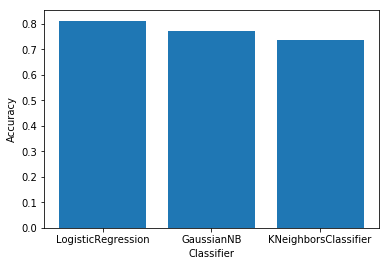

In [9]:
# train and visualize the accuracy for different classifiers

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

X = data_train[:, 1:]
y = data_train[:, 0]

acc_dict2 = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_state)

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    acc_dict2[name] = acc

for clf in acc_dict2:
    log_entry = pd.DataFrame([[clf, acc_dict2[clf]]], columns=log_cols)
    log = log.append(log_entry)

print(log)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

plt.bar(np.arange(3), log['Accuracy'])
plt.xticks(np.arange(3), acc_dict2.keys())
plt.plot()

# Exercise
Use raw values of Pclass for classification i.e. use the PClass column from the data as it is and report the accuracy. Do not map the Pclass to binary values as done before. Also use the Sex of the passenger as the second feature for predicting the survival rate.

             Classifier  Accuracy
0    LogisticRegression  0.826816
0            GaussianNB  0.826816
0  KNeighborsClassifier  0.793296


[]

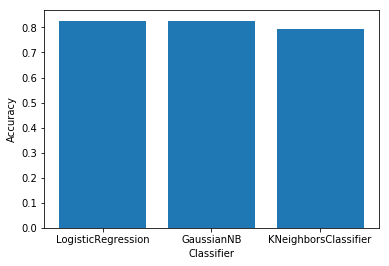

In [10]:
# make a copy of the original dataset
# add code here
train_third_clf = train.copy()
test_third_clf = test.copy()

for dataset in [train_third_clf, test_third_clf]:
    # Map Sex (male , female) to categorical values
    # add code here
    dataset['Sex'] = dataset['Sex'].map( {'female':0., 'male': 1.} ).astype(float)
    
    
# select the features Pclass, Sex and Survived from the training set 
# make sure that first column is Survived column
# add code here

data_train = train_third_clf[["Survived","Pclass","Sex"]]
data_test = test_third_clf[["Pclass","Sex"]]
    
data_train = data_train.values
data_test = data_test.values


log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)


X = data_train[:, 1:]
y = data_train[:, 0]

acc_dict = {}

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# evaluate for different classifiers
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    acc_dict[name] = acc

for clf in acc_dict:
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

print(log)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

plt.bar(np.arange(3), log['Accuracy'])
plt.xticks(np.arange(3), acc_dict.keys())
plt.plot()

# Assignment
Convert the fare data into categorical data and use that information for classification
For this check if all the rows in the data are non zero and/or non NULL. If there's any missing data fill it with some value (choose the values carefully, you can make use of the passenger class to decide on what values to fill)
Once assured that there's no NULL data, convert the fare into three different categories. Here, you are binning continuous values into discrete categories. Note that although the values appear continuous a passenger travelling first class would have paid more than a passenger travelling thrid class. Bin the fares accordingly. Once the fares are binned use the column to classify and report the accuracy.

### Functions that can be handy to handle the Fare data
".groupby" as used previously for predicting the survival rate. Here you can use the function to calculate the median/ mean fare of the passengers and fill these values in places where data is missing

"pd.qcut": This function bins the given column into "N" number of bins based on quantiles. If you have "N=3" then it bins the given column into top 33%, bottom 33% and the middle 33%. Refer to the documentation for more details.

".loc": as used previously to select the required rows and columns and fill the data

In [30]:
## calculate the median fares for each of the passenger classes using .groupby
# add code here
median_fare = train['Fare'].groupby(train['Pclass']).median()

In [31]:
## use pd.qcut to bin the fares into three categories and check the survival rate
train['CategoricalFare'] = pd.qcut(train['Fare'], 3)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0  (-0.001, 8.662]  0.198052
1    (8.662, 26.0]  0.402778
2  (26.0, 512.329]  0.559322


In [43]:
## make a copy of the original data
train_fourth_clf = train.copy()
test_fourth_clf = test.copy()

## map the features into numerical values
for dataset in [train_fourth_clf, test_fourth_clf]:
    # Mapping Sex (male, female) to numerical values
    # add code here
    dataset['Sex'] = dataset['Sex'].map( {'female':0., 'male': 1.} ).astype(float)

    # Fill zero/NULL values in fare according to the passenger class
    # if the passenger is travelling first class "and" his fare information is missing then
    # fill the fare information for that passenger with median fare for first class
    # take care not to replace the existing non-zero/ non-NULL fare information for any of the passengers
    # add code here
    dataset['Fare'][(dataset['Fare']==0)  & (dataset['Pclass']==1)] = median_fare[1]
    dataset['Fare'][(dataset['Fare']==0) & (dataset['Pclass']==2)] = median_fare[2]
    dataset['Fare'][(dataset['Fare']==0) & (dataset['Pclass']==3)] = median_fare[3]
    
    # repeat the same for fares of passengers in second class and third class
    # add code here
    
    # Grouping passengers into three categories based on fare
    dataset.loc[ dataset['Fare'] <= 8.662, 'Fare'] 						        = 1
    dataset.loc[(dataset['Fare'] > 8.662) & (dataset['Fare'] <= 26.0), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 26.0, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(float)
    

# Select the features "Survived, Sex, Pclass, Fare" from the given data
# add code here
data_train = train_third_clf[["Survived","Sex","Pclass","Fare"]]
data_test = test_third_clf[["Sex","Pclass","Fare"]]
    
data_train = data_train.values
data_test = data_test.values

/home/meenu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/meenu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/meenu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


             Classifier  Accuracy
0    LogisticRegression  0.832402
0            GaussianNB  0.821229
0  KNeighborsClassifier  0.804469


[]

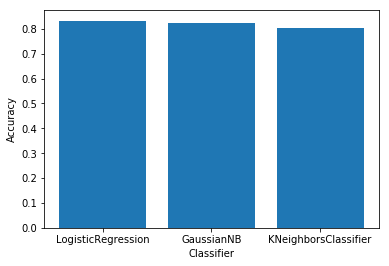

In [56]:
log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

X = data_train[:, 1:]
y = data_train[:, 0]

acc_dict = {}

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# evaluate for different classifiers
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    acc_dict[name] = acc

for clf in acc_dict:
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

print(log)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

plt.bar(np.arange(3), log['Accuracy'])
plt.xticks(np.arange(3), acc_dict.keys())
plt.plot()


## Is Fare a good feature to include in the classification?

Ticket fare paid by a passenger seems to be a good feature for classification if considered independently. However, when we already have the information about the passenger class in which the passenger was travelling this feature becomes somewhat redundant. This is because, a passenger travelling first class would have certainly paid more compared to another passenger travelling third class. Even from the Pearson Correlation map we can see that the feature "Pclass" is highly correlated with the feature "Fare"

![](./PearsonCorrelation.png "Pearson Correlation map")

When we have a lot of features and very less data this is another way of reducing the dimensionality without losing information. If we remove the columns which are highly correlated then, we reduce the dimensionality without sacrificing much on the information